## 最適化問題

$$ \min_h \|\bm{g}-F' \bm{h}\|\_2^2+\lambda_1\|\bm{h}\|\_1 + \lambda_2\|D\bm{h}\|\_1$$


In [12]:
import random
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import re

In [13]:
# パラメータ設定
n = 64
m = 128
N = n**2
M = m**2
LAMBDA1 = 1
LAMBDA2 = 1
SEED = 3
RATIO = 0.1
DATA_PATH = '../../OneDrive - m.titech.ac.jp/Lab/data'
IMG_NAME = 'hadamard'
DIRECTORY = DATA_PATH + '/240626'
SETTING = f"{IMG_NAME}_l1_p-{int(100*RATIO)}_lmd1-{int(LAMBDA1)}_lmd2-{int(LAMBDA2)}_seed-{SEED}"

if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)
if not os.path.exists(DIRECTORY + '/systemMatrix'):
    os.makedirs(DIRECTORY + '/systemMatrix')

In [14]:
# grad
Di = sparse.eye(M, format='csr') - sparse.eye(M, k=m, format='csr')
Di[-m:, :] = 0

Dj = sparse.eye(M, format='csr') - sparse.eye(M, k=1, format='csr')
for p in range(1, m + 1):
    Dj[m * p - 1, m * p - 1] = 0
    if p < m:
        Dj[m * p - 1, m * p] = 0

In [15]:
def matrix2vector(matrix):
    return matrix.T.flatten()


def vector2matrix(vector, s, t):
    """txs matrix"""
    return vector.reshape(s, t).T


def mult_mass(F, h, M):
    N = F.shape[1]
    H = h.reshape(N, M)
    res = F @ H
    return res.flatten()


def mult_Dij(h):
    H = vector2matrix(h, N, M)
    res = np.hstack([Di @ H, Dj @ H])
    return matrix2vector(res)


def mult_DijT(y):
    y1 = y[:M * N]
    y2 = y[M * N:]
    Y1 = vector2matrix(y1, N, M)
    Y2 = vector2matrix(y2, N, M)
    res = Di.T @ Y1 + Dj.T @ Y2
    return matrix2vector(res)


def images_to_matrix(folder_path, convert_gray=True, rand=True, ratio=RATIO):
    files = os.listdir(folder_path)
    files.sort(key=lambda f: int(re.search(f"{IMG_NAME}_(\d+).png", f).group(1)))
    if rand:
        random.seed(SEED)
        random.shuffle(files)

    total_files = len(files)
    number_of_files_to_load = int(total_files * ratio)
    selected_files = files[:number_of_files_to_load]
    selected_files.sort(key=lambda f: int(re.search(f"{IMG_NAME}_(\d+).png", f).group(1)))

    images = []
    use_list = []

    for file in selected_files:
        index = int(re.sub(r'\D', '', file))
        use_list.append(index)
        img = Image.open(os.path.join(folder_path, file))
        if convert_gray:
            img = img.convert('L')
        img_array = np.asarray(img).flatten()
        img_array = img_array / 255
        images.append(img_array)

    return np.column_stack(images), use_list

In [16]:
def prox_l1(x: np.ndarray, alpha: float) -> np.ndarray:
    """Proximal operator for L1 norm."""
    return np.sign(x) * np.maximum(np.abs(x) - alpha, 0)


def prox_l1_conj(x: np.ndarray, alpha: float) -> np.ndarray:
    """Proximal operator for conjugate L1 norm."""
    return x - alpha * prox_l1(x / alpha, 1 / alpha)


def prox_l122(Y, gamma):
    N = Y.shape[1]
    l1_norms = np.sum(np.abs(Y), axis=1)
    factor = (2 * gamma) / (1 + 2 * gamma * N)
    X = np.zeros_like(Y)
    X = np.sign(Y) * np.maximum(np.abs(Y) - factor * l1_norms[:, np.newaxis], 0)
    return X


def primal_dual_splitting(
    F: sparse.csr_matrix,
    g: np.ndarray,
    lambda1: float,
    lambda2: float,
    max_iter: int = 1000,
    tol: float = 1e-2,
) -> tuple[np.ndarray, dict]:
    """
    Solve the optimization problem:
    min_h ||g-Fh||_2^2 + lambda1||h||_1 + lambda2||Dh||_1
    using the primal-dual splitting method.

    Args:
        F (np.ndarray): Matrix F in the problem formulation.
        g (np.ndarray): Vector g in the problem formulation.
        lambda1 (float): Regularization parameter for L1 norm of h.
        lambda2 (float): Regularization parameter for L1 norm of Dh.
        h_init (np.ndarray, optional): Initial guess for h. If None, initialized with zeros.
        y_init (np.ndarray, optional): Initial guess for y. If None, initialized with zeros.
        max_iter (int): Maximum number of iterations.
        tol (float): Tolerance for convergence.
        adaptive_params (bool): Whether to use adaptive step sizes.

    Returns:
        tuple[np.ndarray, dict]: Solution h and a dictionary containing additional information.
    """
    h = np.zeros(N * M)
    y = np.zeros(2 * N * M)

    # Initialize step sizes
    tau = 1.0 / (np.linalg.norm(F, 2) ** 2)  # 1 / Compute Lipschitz constant of grad_f
    sigma = 1.0 / ((2 * M * N * 2) ** 2)  # 1 / l2 norm of Dij ^ 2

    # objective_values = []
    for k in range(max_iter):
        h_old = h.copy()
        y_old = y.copy()

        # Update primal variable h
        grad = mult_mass(F.T, (mult_mass(F, h_old, m ** 2) - g), m ** 2)
        h = prox_l1(h - tau * (grad - mult_DijT(y)), tau * lambda1)

        # Update dual variable y
        y = prox_l1_conj(y + sigma * mult_Dij(2 * h - h_old), sigma / lambda2)

        # Compute objective value
        # obj_value = np.linalg.norm(
        #     g - mult_mass(F, h, m**2))**2 + lambda1 * np.linalg.norm(h, 1) + lambda2 * np.linalg.norm(mult_Dij(h), 1)
        # objective_values.append(obj_value)

        # Check convergence
        primal_residual = np.linalg.norm(h - h_old)
        dual_residual = np.linalg.norm(y - y_old)
        print(
            f"iter={k}, primal_res={primal_residual:.4f}, dual_res={dual_residual:.4f}")
        if primal_residual < tol and dual_residual < tol:
            break

    info = {
        "iterations": k + 1,
        # "objective_values": objective_values,
        # "final_objective": objective_values[-1],
        "primal_residual": primal_residual,
        "dual_residual": dual_residual
    }

    return h, info

In [17]:
# load images
G, use = images_to_matrix(f"{DATA_PATH}/{IMG_NAME}{n}_cap_R_230516_128/")
F, _ = images_to_matrix(f"{DATA_PATH}/{IMG_NAME}{n}_input/")
print("K=", F.shape[1])
white_img = Image.open(f"{DATA_PATH}/{IMG_NAME}{n}_cap_R_230516_128/{IMG_NAME}_1.png")
white_img = white_img.convert('L')
white_img = np.asarray(white_img) / 255
white = white_img.flatten()
white = white[:, np.newaxis]
H1 = np.tile(white, F.shape[1])
F_hat = 2 * F - 1
G_hat = 2 * G - H1

g = matrix2vector(G_hat)

K= 409


In [18]:
# Dk = sparse.eye(N, format='csr') - sparse.eye(N, k=n, format='csr')
# Dk = sparse.csr_matrix(Dk[:n * (n - 1), :N])
# Dk = sparse.vstack([Dk, sparse.csr_matrix((n, N))])

In [19]:
# Dl = sparse.eye(N, format='csr') - sparse.eye(N, k=1, format='csr')
# for p in range(1, n + 1):
#     Dl[n * p - 1, n * p - 1] = 0
#     if p < n:
#         Dl[n * p - 1, n * p] = 0

In [20]:
# DI = sparse.kron(sparse.eye(N, format='csr'), Di)
# DJ = sparse.kron(sparse.eye(N, format='csr'), Dj)
# DK = sparse.kron(Dk, sparse.eye(M, format='csr'))
# DL = sparse.kron(Dl, sparse.eye(M, format='csr'))

In [21]:
h, info = primal_dual_splitting(F_hat.T, g, LAMBDA1, LAMBDA2)

iter=0, primal_res=1.8115, dual_res=0.0000
iter=1, primal_res=0.4204, dual_res=0.0000
iter=2, primal_res=0.3425, dual_res=0.0000
iter=3, primal_res=0.2980, dual_res=0.0000
iter=4, primal_res=0.2681, dual_res=0.0000
iter=5, primal_res=0.2463, dual_res=0.0000
iter=6, primal_res=0.2294, dual_res=0.0000
iter=7, primal_res=0.2158, dual_res=0.0000
iter=8, primal_res=0.2046, dual_res=0.0000
iter=9, primal_res=0.1950, dual_res=0.0000
iter=10, primal_res=0.1868, dual_res=0.0000
iter=11, primal_res=0.1797, dual_res=0.0000
iter=12, primal_res=0.1733, dual_res=0.0000
iter=13, primal_res=0.1676, dual_res=0.0000
iter=14, primal_res=0.1624, dual_res=0.0000
iter=15, primal_res=0.1577, dual_res=0.0000
iter=16, primal_res=0.1534, dual_res=0.0000
iter=17, primal_res=0.1494, dual_res=0.0000
iter=18, primal_res=0.1456, dual_res=0.0000
iter=19, primal_res=0.1420, dual_res=0.0000
iter=20, primal_res=0.1387, dual_res=0.0000
iter=21, primal_res=0.1355, dual_res=0.0000
iter=22, primal_res=0.1324, dual_res=0.000

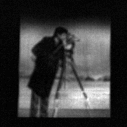

In [22]:
H = vector2matrix(h, n**2, m**2)
np.save(f"{DIRECTORY}/systemMatrix/H_matrix_{SETTING}.npy", H)

sample_image = Image.open(f"{DATA_PATH}/sample_image64/Cameraman64.png").convert('L')
sample_image = np.asarray(sample_image).flatten() / 255

Hf = H @ sample_image
Hf_img = Hf.reshape(m, m)
Hf_img = np.clip(Hf_img, 0, 1)
Hf_pil = Image.fromarray((Hf_img * 255).astype(np.uint8), mode='L')

FILENAME = f"Cameraman64_{SETTING}.png"
fig, ax = plt.subplots(figsize=Hf_img.shape[::-1], dpi=1, tight_layout=True)
ax.imshow(Hf_pil, cmap='gray')
ax.axis('off')
fig.savefig(f"{DIRECTORY}/{FILENAME}", dpi=1)
plt.show()